# Sprint
## 機械学習スクラッチ クラスタリング
スクラッチでK-meansを実装した後、それを使用しクラスタ分析を行います。

K-meansのクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


以下に雛形を用意してあります。このScratchKMeansクラスにコードを書き加えていってください。

In [34]:
import numpy as np
import time
class ScratchKMeans():
    """
    K-meansのスクラッチ実装

    Parameters
    ----------
    n_clusters : int
      クラスタ数
    n_init : int
      中心点の初期値を何回変えて計算するか
    max_iter : int
      1回の計算で最大何イテレーションするか
    tol : float
      イテレーションを終了する基準となる中心点と重心の許容誤差
    verbose : bool
      学習過程を出力する場合はTrue
    
    Attributes
    ----------
    self.mu : ndarray(n_clusters, n_features)
      クラスタの中心点
    self.r_binary : ndarray(n_samples, n_clusters)
      サンプル毎の所属クラスタをone-hot表現で表した配列
    self.sse : [float]
      クラスタ内誤差平方和（SSE）の推移
    """
    def __init__(self, n_clusters, n_init, max_iter, tol, verbose=False):
        # ハイパーパラメータを属性として記録
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
    
    def fit(self, X):
        """
        K-meansによるクラスタリングを計算
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        """
        # preparing
        n_samples = X.shape[0]
        self.mu = None
        self.r_binary = None
        self.sse = [-1]

        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print('start learning')
        
        start_time = time.time()

        # learning
        for j in range(self.n_init):
            tmp_mu = X[np.random.choice(n_samples, self.n_clusters, replace=False), :]
            tmp_r_binary = None
            tmp_sse = []
            for i in range(self.max_iter):
                # break flag
                _break = False
                
                # assign cluster
                tmp_r_binary = self._assign_cluster(X, tmp_mu)

                # diff old mu /new mu
                _mu_new = self._move_mu(X, tmp_r_binary)
                _diff = np.sqrt(self._each_diff_norm_squared(_mu_new, tmp_mu))
                
                # 微小な負数の平方根を計算しようとしてnanが出ることがあるので回避
                _diff_sum = np.nansum(np.diag(_diff))
                if _diff_sum < self.tol:
                    _break = True
                tmp_mu = _mu_new

                # calc new sse
                tmp_sse.append(self._calc_SSE(X, tmp_r_binary, tmp_mu))
                if self.verbose:
                    print(f'{j+1},{i+1} SSE: {tmp_sse[-1]}')

                if _break: break
            # update mu / r_binary / sse
            if (tmp_sse[-1] < self.sse[-1]) or (self.sse[-1] < 0):
                self.mu = tmp_mu
                self.r_binary = tmp_r_binary
                self.sse = tmp_sse
        
        end_time = time.time()
        elapsed_time = end_time - start_time

        print(f'Done! elapsed time: {elapsed_time:.5f}s')
    
    def predict(self, X):
        """
        入力されたデータがどのクラスタに属するかを計算
        Return
        ----------
          ndarray(n_samples, )
            所属クラスタをrange(0, n_clusters)で表現した一次元配列
        """
        # assign cluster
        _r_binary = self._assign_cluster(X, self.mu)

        # make output data
        cluster_num = np.full(X.shape[0], -1)
        for c in range(self.n_clusters):
            cluster_num[np.nonzero(_r_binary[:, c])] = c

        return cluster_num

    def _each_diff_norm_squared(self, A, B):
        """
        行列A,Bから一行ずつ選び出し、その差のベクトルのノルムの二乗||(A_i)-(B_j)||^2を計算する

        Parameters
        ----------
        A, B : ndarray
            行列 1行が一つのベクトルに対応している
        Return
        ----------
          ndarray(A.shape[0], B.shape(0))
        """
        A_norm = np.linalg.norm(A, axis=1)

        B_norm = np.linalg.norm(B, axis=1)

        A_dot_B = A@B.T

        norm_squared = A_norm.reshape(-1, 1)**2 + B_norm**2 - 2*A_dot_B

        return norm_squared

    def _calc_SSE(self, X, r_binary, mu):
        """ 
        クラスタ内誤差平方和を計算する。

        """
        # calc sse
        _sse = np.sum(r_binary * self._each_diff_norm_squared(X, mu))

        return _sse

    def _assign_cluster(self, X, mu):
        """
        データ点をもっとも近い中心点が属するクラスタに割り当てる
        """
        # calc norm
        _each_diff_norm = self._each_diff_norm_squared(X, mu)

        # one-hot
        _r_binary = np.zeros((X.shape[0], self.n_clusters))
        _r_binary[range(_r_binary.shape[0]), np.argmin(_each_diff_norm, axis=1)] = 1

        return _r_binary

    def _move_mu(self, X, r_binary):
        """
        クラスタの中心点の位置をクラスタの重心まで移動する
        """
        mu_new = np.zeros((self.n_clusters, X.shape[1]))

        for k in range(self.n_clusters):
            mask = np.nonzero(r_binary[:, k])
            mu_new[k] = np.mean(X[mask], axis=0)
        
        return mu_new

    def get_silhouette_val(self, X):
      """
      シルエット係数を求める
      """
      _silhouette_vals = np.zeros(X.shape[0])
      _cluster_num = self.predict(X)

      for i, (x, c_num) in enumerate(zip(X, _cluster_num)):
        # 凝集度
        other_point_num = np.unique(_cluster_num, return_counts=True)[1][c_num] - 1
        a = np.nansum(
          np.sqrt(
            self._each_diff_norm_squared(
              x.reshape(1, x.shape[0]),
              X[_cluster_num == c_num])
            )
          ) / other_point_num
        # 剥離度
        nearest_cluster_ind = self._get_nearest_cluster(x, c_num)
        b = np.mean(
          np.sqrt(
            self._each_diff_norm_squared(
              x.reshape(1, x.shape[0]),
              X[_cluster_num == nearest_cluster_ind])
            )
          )

        # シルエット係数計算
        _silhouette_vals[i] = (b-a) / max(a, b)
      
      return _silhouette_vals 

    def _get_nearest_cluster(self, point, cluster_num):
      """
      最も近い他のクラスタのインデックスを求める
      中心点に対して距離を求める。
      Parameter
      ----------
      point : ndarray(1, n_features) 
          基準点の座標
      cluster_num : int
          基準点が属するクラスタのインデックス    
      Return
      ----------
        int
          最も近いクラスタのインデックス
      """
      index = -1
      distance = -1

      for i, _mu in enumerate(self.mu):
        # 自身が属するクラスタに対しては計算しない
        if i == cluster_num: continue

        tmp_dist = point@_mu.T
        if (tmp_dist < distance) or (distance == -1):
          index = i
          distance = tmp_dist
        
      return index

## クラスタリングのための人工データセット
クラスタリングを実験するための人工データセットを作成するコードを用意しています。


この`make_blobs`関数は正解ラベルも出力してますが、今回は使用しません。使用しないことを明示するために、 \_（アンダースコア） で受け取っています。


**《シンプルデータセット3》**

In [35]:
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)
print(X)

[[ 0.72086751  3.71347124]
 [-1.89468423  7.96898545]
 [ 1.35678894  4.36462484]
 [ 1.05374379  4.49286859]
 [ 1.59141542  4.90497725]
 [ 0.78260667  4.15263595]
 [-1.95751686  3.87291474]
 [-0.77354537  7.87923564]
 [ 0.12313498  5.27917503]
 [-1.43284669  7.71577043]
 [-0.92819001  7.02698199]
 [-1.74836345  7.06307447]
 [-1.26789718  7.25141327]
 [-0.98661744  7.74968685]
 [-0.81984047  7.50994722]
 [ 2.99684287  0.22378413]
 [ 1.46870582  1.86947425]
 [-0.33533163  3.390122  ]
 [-1.86407034  2.93379754]
 [ 2.62496786  0.28025075]
 [ 2.11114739  3.57660449]
 [-1.8219901   7.61654999]
 [-1.91186205  3.18750686]
 [ 2.28809874  0.12954182]
 [ 0.5285368   4.49723858]
 [-1.57613028  2.58614312]
 [-0.565433    3.65813966]
 [ 0.802314    4.38196181]
 [ 2.79939362  1.84560825]
 [ 2.64465731  0.80770124]
 [ 1.7190373   0.71788708]
 [-0.93564005  7.03443119]
 [ 2.14398059  0.69677319]
 [ 2.06051753  1.79059891]
 [-1.21986433  3.3789856 ]
 [ 1.13280393  3.87673946]
 [-1.497272    8.80022604]
 

# 【問題1】
## 中心点の初期値を決める
入力されたデータから$K$個の中心点$μ_1$から$μ_K$の初期値を決めるコードを作成してください。$K$は指定したクラスタ数です。


最もシンプルな初期値の決定方法は、データ点$X_n$の中からランダムに$K$個選ぶことです。今回はこれを実装してください。


K-meansの学習結果は中心点$μ$の初期値に影響を受けます。そのため、学習時には複数個の初期値で計算を行います。

```python
n_samples = X.shape[0]
self.mu = X[np.random.randint(0, n_samples, self.n_clusters), :]
```

# 【問題2】
## SSEを求める関数の作成
クラスタ内誤差平方和（SSE, Sum of Squared Errors）を計算する関数を作成してください。


K-meansはこのSSEを最小化する$r_{nk}$と$\mu_k$を求めることが目的となります。複数個の初期値で計算したクラスタリング結果から、どれを最終的に採用するかを決める際にこのSSEを求める関数を使用します。

$$
SSE = \sum_{n=1}^N \sum_{k=1}^K r_{nk} \|X_n - \mu_k\|^2
$$

$n$ : データ点のインデックス


$k$ : クラスタのインデックス


$X_n$ : $n$番目のデータ点


$\mu_k$ : $k$番目の中心点


$r_{nk}$ : データ点$X_n$がクラスタ$k$に所属していたら1、そうでなければ0

以下の式から計算する。
$$
\|A-B\|^2 = \|A\|^2 + \|B\|^2 - 2*(A \cdot B)
$$
-> `_each_diff_norm_squared(A, B)`
```python
    def _each_diff_norm_squared(self, A, B):
        """
        行列A,Bから一行ずつ選び出し、その差のベクトルのノルムの二乗||(A_i)-(B_j)||^2を計算する

        Parameters
        ----------
        A, B : ndarray
            行列 1行が一つのベクトルに対応している
        Return
        ----------
          ndarray(A.shape[0], B.shape(0))
        """
        A_norm = np.linalg.norm(A, axis=1)

        B_norm = np.linalg.norm(B, axis=1)

        A_dot_B = A@B.T

        norm_squared = A_norm.reshape(-1, 1)**2 + B_norm**2 - A_dot_B

        return norm_squared

    def _calc_SSE(self, X):
        """ 
        クラスタ内誤差平方和を計算する。

        """
        # calc sse
        _sse = np.sum(self.r_binary * self._each_diff_norm_squared(X, self.mu))

        return _sse
```

## クラスタの割り当てと中心点の移動を繰り返す
K-meansの学習の基本は以下の2つのフェーズを繰り返すことです。


- 中心点$\mu_k$を固定した上で$SSE$を最小化するクラスタの割り当て$r_{nk}$を選ぶ。
- クラスタの割り当て$r_{nk}$を固定した上で$SSE$を最小化する中心点$\mu_k$を選ぶ。

最初の中心点$\mu_k$は問題1で作成した初期値です。


順番に見ていきます。

# 【問題3】
## クラスタへの割り当て
全てのデータ点$X_n$を最も近い中心点$\mu_k$に割り当てるコードを作成してください。


K-menasにおける**近い**とは点と点のユークリッド距離が小さくなることです。ユークリッド距離とはピタゴラスの定理（三平方の定理）で求められるものですが、ベクトル$p, q$に対しては以下の数式で表現できます。

$$
\|q-p\| = \sqrt{(q-p)\cdot(q-p)}
$$

NumPyにはこの関数がnp.linalg.normとして用意されているため使用してください。


[numpy.linalg.norm — NumPy v1.17 Manual](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html)


中心点$\mu_k$を固定した上でSSEを最小化していることになりますが、SSE自体を求める必要はありません。

実数空間においては$\|x\|\geq0$であるから、$\|a\|\geq\|b\|$のとき$\|a\|^2\geq\|b\|^2$もまた成り立つ。

よって、簡単のためにユークリッド距離の比較は$\|q-p\|^2$を用いて行う。 -> `_each_diff_norm_squared(A, B)`
```python
    def _assign_cluster(self, X):
        """
        データ点をもっとも近い中心点が属するクラスタに割り当てる
        """
        # calc norm
        _each_diff_norm = self._each_diff_norm_squared(X, self.mu)

        # one-hot
        _r_binary = np.zeros((X.shape[0], self.n_clusters))
        _r_binary[range(_r_binary.shape[0]), np.argmin(_each_diff_norm, axis=1)] = 1

        return _r_binary
```

# 【問題4】
## 中心点の移動
中心点$\mu_k$を$k$番目のクラスタに割り当てられる全てのデータ点$X_n$の平均値（重心）に移動するコードを作成してください。


クラスタの割り当て$r_{nk}$を固定した上でSSEを最小化していることになりますが、SSE自体を求める必要はありません。

```python
    def _move_mu(self, X):
        """
        クラスタの中心点の位置をクラスタの重心まで移動する
        """
        mu_new = np.zeros((self.n_clusters, X.shape[1]))

        for k in range(self.n_clusters):
            mask = np.nonzero(self.r_binary[:, k])
            mu_new[k] = np.mean(X[mask], axis=0)
        
        return mu_new
```

# 【問題5】
## 繰り返し
クラスタへの割り当てと中心点の移動を繰り返すことで学習を行うコードを作成してください。


次のどれかの条件を満たしたらこれを止めます。


- 繰り返しが指定した回数に到達する。（雛形では引数max_iter）
- 中心点$\mu_k$と重心の差の合計が指定した許容値以下になる。（雛形では引数tol）


# 【問題6】
## 異なる初期値で計算
問題5の繰り返しを、指定した回数初期値を変更して計算するコードを作成してください。回数は雛形では引数n_initで指定します。


複数計算した中でSSEが最小になったものが最終的な学習結果となるため、その時の中心点$\mu_k$を保持しておきます。

以下コードは問題5, 6に対応
```python
    def fit(self, X):
        """
        K-meansによるクラスタリングを計算
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        """
        # preparing
        n_samples = X.shape[0]
        self.mu = None
        self.r_binary = None
        self.sse = [-1]

        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print('start learning')
        
        start_time = time.time()

        # learning
        for j in range(self.n_init):
            tmp_mu = X[np.random.choice(n_samples, self.n_clusters, replace=False), :]
            tmp_r_binary = None
            tmp_sse = []
            for i in range(self.max_iter):
                # break flag
                _break = False
                
                # assign cluster
                tmp_r_binary = self._assign_cluster(X, tmp_mu)

                # diff old mu /new mu
                _mu_new = self._move_mu(X, tmp_r_binary)
                _diff = np.sqrt(self._each_diff_norm_squared(_mu_new, tmp_mu))
                
                # 微小な負数の平方根を計算しようとしてnanが出ることがあるので回避
                _diff_sum = np.nansum(np.diag(_diff))
                if _diff_sum < self.tol:
                    _break = True
                tmp_mu = _mu_new

                # calc new sse
                tmp_sse.append(self._calc_SSE(X, tmp_r_binary, tmp_mu))
                if self.verbose:
                    print(f'{j+1},{i+1} SSE: {tmp_sse[-1]}')

                if _break: break
            # update mu / r_binary / sse
            if (tmp_sse[-1] < self.sse[-1]) or (self.sse[-1] < 0):
                self.mu = tmp_mu
                self.r_binary = tmp_r_binary
                self.sse = tmp_sse
        
        end_time = time.time()
        elapsed_time = end_time - start_time

        print(f'Done! elapsed time: {elapsed_time:.5f}s')
```

# 【問題7】
## 推定
新たなデータに対してどのクラスタに所属するかの推定の際は、学習時の1つ目のフェーズと同じことを行います。


- データ点$X_n$と学習で決まった中心点$\mu_k$に対し、$SSE$を最小化する$r_{nk}$を選ぶ。

具体的には次のことです。


- データ点$X_n$を最も近い$\mu_k$に割り当てる。

```python
    def predict(self, X):
        """
        入力されたデータがどのクラスタに属するかを計算
        Return
        ----------
          ndarray(n_samples, )
            所属クラスタをrange(0, n_clusters)で表現した一次元配列
        """
        # assign cluster
        _r_binary = self._assign_cluster(X, self.mu)

        # make output data
        cluster_num = np.full(X.shape[0], -1)
        for c in range(self.n_clusters):
            cluster_num[np.nonzero(_r_binary[:, c])] = c

        return cluster_num
```

-> 問題5, 6で実装済み

実際に学習・予測を行ってみる。

In [36]:
skm = ScratchKMeans(n_clusters=4, n_init=20, max_iter=20, tol=1.0e-6, verbose=True)
skm.fit(X)

start learning
1,1 SSE: 104.82748165877555
1,2 SSE: 57.669036908724976
1,3 SSE: 48.633783207064134
1,4 SSE: 48.633783207064134
2,1 SSE: 135.9193342363602
2,2 SSE: 134.74558053257792
2,3 SSE: 134.48843877933666
2,4 SSE: 134.38175056942373
2,5 SSE: 134.38175056942373
3,1 SSE: 244.03221624605845
3,2 SSE: 218.2337751486812
3,3 SSE: 142.22387483400323
3,4 SSE: 56.57022645923886
3,5 SSE: 48.633783207064134
3,6 SSE: 48.633783207064134
4,1 SSE: 201.6193402526539
4,2 SSE: 192.59784719415063
4,3 SSE: 183.5027245724355
4,4 SSE: 132.46893122305133
4,5 SSE: 56.55621297152878
4,6 SSE: 48.633783207064134
4,7 SSE: 48.633783207064134
5,1 SSE: 364.24997887612784
5,2 SSE: 308.15151773436696
5,3 SSE: 254.7032978039892
5,4 SSE: 251.64564708432314
5,5 SSE: 245.58872385863424
5,6 SSE: 219.6304785777716
5,7 SSE: 134.3848583413166
5,8 SSE: 134.3848583413166
6,1 SSE: 289.0444625773582
6,2 SSE: 234.20730041037186
6,3 SSE: 216.18665948357273
6,4 SSE: 161.5386389506451
6,5 SSE: 127.5623951969474
6,6 SSE: 80.999156

In [37]:
print(skm.r_binary)

[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0.

In [38]:
import matplotlib.pyplot as plt
def plot_cluster(X, model):
    """
    与えられたデータから所属クラスタを予測してプロットする
    """
    _assigned_cluster = model.predict(X)
    _mu = model.mu

    %matplotlib inline
    plt.title('K-means clustering')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    for c in range(model.n_clusters):
        Xc = X[_assigned_cluster == c]
        plt.scatter(Xc[:, 0], Xc[:, 1], label=c)

    plt.scatter(_mu[:, 0], _mu[:, 1], marker='x', label="mu")
    plt.legend()
    plt.show()

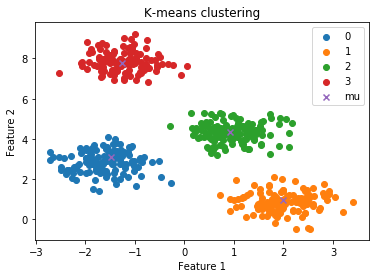

In [39]:
X_test, _ = make_blobs(n_samples=500, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)
plot_cluster(X_test, skm)

# 【問題8】
## エルボー法の実装
K-meansにおいて中心点の個数$k$は人為的に決める必要がありますが、その判断方法としてエルボー法があります。エルボー法により中心点の個数$k$を検討するためのコードを作成してください。


SSEを縦軸、クラスタ数$k$を横軸にした折れ線グラフを表示します。このためにK-meansのインスタンスからはSSEを取得できるようにしてください。

In [40]:
def plot_elbow(X, range_):
    sse_elbow = []

    for i in range(1, range_+1):
        skm = ScratchKMeans(n_clusters=i, n_init=50, max_iter=50, tol=1.0e-6)
        skm.fit(X)
        sse_elbow.append(skm.sse[-1])

    %matplotlib inline
    plt.title('Elbow plot')
    plt.xlabel('num cluster')
    plt.xticks(range(1, range_+1))
    plt.ylabel('SSE')

    plt.plot(range(1, range_+1), sse_elbow, marker='o', markersize=7)

    plt.show()

Done! elapsed time: 0.03595s
Done! elapsed time: 0.08183s
Done! elapsed time: 0.07189s
Done! elapsed time: 0.07618s
Done! elapsed time: 0.09775s
Done! elapsed time: 0.09355s
Done! elapsed time: 0.09981s
Done! elapsed time: 0.11088s
Done! elapsed time: 0.12908s
Done! elapsed time: 0.12556s


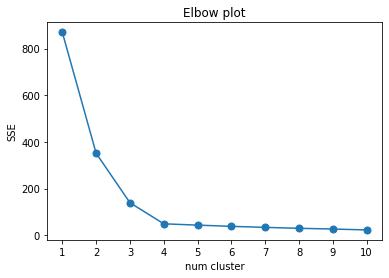

In [41]:
plot_elbow(X, 10)

クラスタ数4程度で減少率が大きく低下していることが分かる。

# 【問題9】
## （アドバンス課題）シルエット図
$k$を決める助けになるものとしてシルエット図もあります。シルエット図を表示するコードを作成してください。


Matplotlibを使い図を表示するコードは用意しました。以下を与えてください。


`silhouette_vals` : shape(n_samples,)のndarray、各データ点のシルエット係数


`silhouette_avg` : float、シルエット係数の平均値


`y_km` : shape(n_samples,)のndarray、各データ点のクラスタラベル名


`cluster_labels` : ~~list~~ ndarray（じゃないと表示用コードは動かなさそう）、クラスタのラベル名のリスト


`n_clusters` : int、クラスタ数


$n$番目のデータ点に対するシルエット係数$s_n$は以下の数式でを求められます。この数式を実装し、シルエット図を確認してください。

$$
s_n = \frac{b_n-a_n}{max(b_n,a_n)}
$$

$a_n$ : 凝集度。同じクラスタ内の他のデータ点との距離の平均値。


$b_n$ : 乖離度。最も近い他のクラスタ内の全てのデータ点との距離の平均値。


乖離度$b$が大きく、凝集度$b$が小さい時が理想的であり、シルエット係数$s$は1に近くなります。

numpyの行列計算が煩雑で思いつかなかったためforループで計算。
```python
    def get_silhouette_val(self, X):
      """
      シルエット係数を求める
      """
      _silhouette_vals = np.zeros(X.shape[0])
      _cluster_num = self.predict(X)

      for i, (x, c_num) in enumerate(zip(X, _cluster_num)):
        # 凝集度
        other_point_num = np.unique(_cluster_num, return_counts=True)[1][c_num] - 1
        a = np.nansum(
          np.sqrt(
            self._each_diff_norm_squared(
              x.reshape(1, x.shape[0]),
              X[_cluster_num == c_num])
            )
          ) / other_point_num
        # 剥離度
        nearest_cluster_ind = self._get_nearest_cluster(x, c_num)
        b = np.mean(
          np.sqrt(
            self._each_diff_norm_squared(
              x.reshape(1, x.shape[0]),
              X[_cluster_num == nearest_cluster_ind])
            )
          )

        # シルエット係数計算
        _silhouette_vals[i] = (b-a) / max(a, b)
      
      return _silhouette_vals

    def _get_nearest_cluster(self, point, cluster_num):
      """
      最も近い他のクラスタのインデックスを求める
      中心点に対して距離を求める。
      Parameter
      ----------
      point : ndarray(1, n_features) 
          基準点の座標
      cluster_num : int
          基準点が属するクラスタのインデックス    
      Return
      ----------
        int
          最も近いクラスタのインデックス
      """
      index = -1
      distance = -1

      for i, _mu in enumerate(self.mu):
        # 自身が属するクラスタに対しては計算しない
        if i == cluster_num: continue

        tmp_dist = point@_mu.T
        if (tmp_dist < distance) or (distance == -1):
          index = i
          distance = tmp_dist
        
      return index

```

In [42]:
silhouette_vals = skm.get_silhouette_val(X)
silhouette_avg = np.mean(silhouette_vals)
y_km = skm.predict(X)
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]

# check vals
print(silhouette_vals)
print(silhouette_vals.shape)
print(silhouette_avg)
print(y_km)
print(cluster_labels)
print(n_clusters)

[0.70392705 0.88871342 0.78104591 0.82113697 0.73006332 0.80223822
 0.78550691 0.89211295 0.70234811 0.91069233 0.85166731 0.85679639
 0.88799031 0.90370672 0.88493238 0.7417962  0.63572528 0.61167398
 0.83291915 0.78087913 0.41857644 0.890964   0.83844235 0.78040787
 0.79833585 0.79609118 0.67417642 0.82087121 0.69595452 0.80549088
 0.82433187 0.85305938 0.83931266 0.73176331 0.8169778  0.73523186
 0.8571323  0.78035554 0.81341478 0.77787618 0.77001601 0.84176604
 0.82016257 0.82190166 0.825044   0.88171506 0.80307088 0.84221288
 0.78924092 0.55083924 0.7717049  0.84062045 0.80211402 0.79727546
 0.67289946 0.90287888 0.88642369 0.82666999 0.82208823 0.88134921
 0.87780154 0.7528094  0.83766882 0.69603668 0.738521   0.88021668
 0.78068818 0.73844415 0.80834479 0.8071692  0.89094792 0.75559563
 0.82466238 0.91017265 0.80866206 0.70886396 0.69095541 0.84553851
 0.82709663 0.71805031 0.73698364 0.87026178 0.81741757 0.73278902
 0.82633934 0.77508615 0.8097732  0.81988309 0.68897204 0.8240

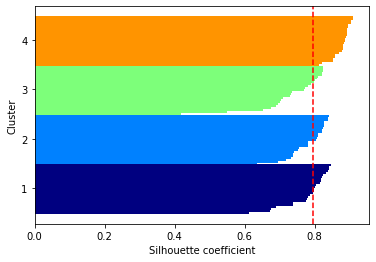

In [43]:
# 《シルエット図を表示するためのコード》
from matplotlib import cm
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()

## 卸売業者のデータ分析
クラスタリングを利用法を学ぶために、Wholesale customers Data Setを使用します。


[UCI Machine Learning Repository: Wholesale customers Data Set](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers)


Data Folderの中から`Wholesale customers data.csv`をダウンロードしてください。これはポルトガルのリスボンにある卸売業者（wholesale）が顧客から集めたデータです。中身は各顧客が年間でミルクや食料品を何ユーロ購入しているかというデータになっています。顧客は小売店やレストランです。`Region`と`Channel`は取り覗き、金額のデータでK-meansを利用します。

## 次元削減
金額に関する特徴量は6個ありますが、可視化するために次元削減を行います。これに関してはscikit-learnによるPCAのサンプルコードを用意したので利用してください。

**《PCAのサンプルコード》**
```python
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca = pca.fit(data)
data_pca = pca.transform(data)
```

**《PCAの分散説明率を表示するコードサンプル》**
```python
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=None)
pca = pca.fit(data)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)
plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()
```

In [44]:
import pandas as pd
data = pd.read_csv('Wholesale customers data.csv')
data = data.drop(['Channel', 'Region'], axis=1)
display(data)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...
435,29703,12051,16027,13135,182,2204
436,39228,1431,764,4510,93,2346
437,14531,15488,30243,437,14841,1867
438,10290,1981,2232,1038,168,2125


[[  650.02212207  1585.51909007]
 [-4426.80497937  4042.45150884]
 [-4841.9987068   2578.762176  ]
 [  990.34643689 -6279.80599663]
 [10657.99873116 -2159.72581518]]


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.976537,0.121184,0.061540,0.152365,-0.007054,0.068105
1,-0.110614,0.515802,0.764606,-0.018723,0.365351,0.057079


[0.45961362 0.86478588]


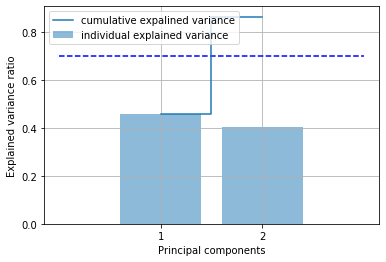

In [45]:
# PCA使ってみる
from sklearn.decomposition import PCA

## 次元削減
pca = PCA(n_components = 2)
pca = pca.fit(data)
data_pca = pca.transform(data)
print(data_pca[:5])
pca_components_df = pd.DataFrame(data=pca.components_,columns=data.columns)
display(pca_components_df.head())

## 分散説明率
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)
plt.bar(range(1,3), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1, 3), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.xticks(range(1, 3))
plt.hlines(0.7, 0, 3,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

# 【問題10】
## クラスタ数kの選択
最適だと思われるクラスタ数$k$を選択してください。エルボー法やシルエット図を活用する他、人間が後々どう利用したいのかも選択に関わってきます。選択した上で、なぜそれを選んだか説明してください。

In [46]:
# エルボー図描画用関数　SSEの減少率も表示する
def plot_elbow_new(X, range_, figsize=(6, 4)):
    sse_elbow = []

    for i in range(1, range_+1):
        print(f'step {i}:', end='')
        skm = ScratchKMeans(n_clusters=i, n_init=50, max_iter=50, tol=1.0e-6)
        skm.fit(X)
        sse_elbow.append(skm.sse[-1])

    decrease = [(x/sse_elbow[i]) for i, x in enumerate(sse_elbow[1:])]

    %matplotlib inline
    fig = plt.figure(figsize=figsize)
    plt.title('Elbow plot')
    plt.xlabel('num cluster')

    ax1 = fig.add_subplot(111)
    ax1.set_xticks(range(1, range_+1))
    ax1.set_ylabel('SSE')
    plt.plot(range(1, range_+1), sse_elbow, color='b', marker='o', markersize=7, label='SSE')
    
    ax2 = ax1.twinx()
    ax2.set_xticks(range(1, range_+1))
    ax2.set_ylabel('Decrease')
    ax2.set_ylim(0.5, 1.0)
    plt.plot(range(2, range_+1), decrease, color='r', marker='x', markersize=7, label='Decrease')

    plt.legend()
    plt.show()

In [47]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_pca_std = scaler.fit_transform(data_pca)

step 1:Done! elapsed time: 0.05451s
step 2:Done! elapsed time: 0.28186s
step 3:Done! elapsed time: 0.34813s
step 4:Done! elapsed time: 0.44200s
step 5:Done! elapsed time: 0.50084s
step 6:Done! elapsed time: 0.64740s
step 7:Done! elapsed time: 0.65467s
step 8:Done! elapsed time: 0.61797s
step 9:Done! elapsed time: 0.73039s
step 10:Done! elapsed time: 0.79376s
step 11:Done! elapsed time: 0.90677s
step 12:Done! elapsed time: 0.93626s
step 13:Done! elapsed time: 0.94328s
step 14:Done! elapsed time: 1.15358s
step 15:Done! elapsed time: 1.14249s
step 16:Done! elapsed time: 1.12272s
step 17:Done! elapsed time: 1.23469s
step 18:Done! elapsed time: 1.28506s
step 19:Done! elapsed time: 1.23191s
step 20:Done! elapsed time: 1.08799s
step 21:Done! elapsed time: 1.27214s
step 22:Done! elapsed time: 1.30739s
step 23:Done! elapsed time: 1.27996s
step 24:Done! elapsed time: 1.20398s
step 25:Done! elapsed time: 1.32102s
step 26:Done! elapsed time: 1.19974s
step 27:Done! elapsed time: 1.29909s
step 28:Do

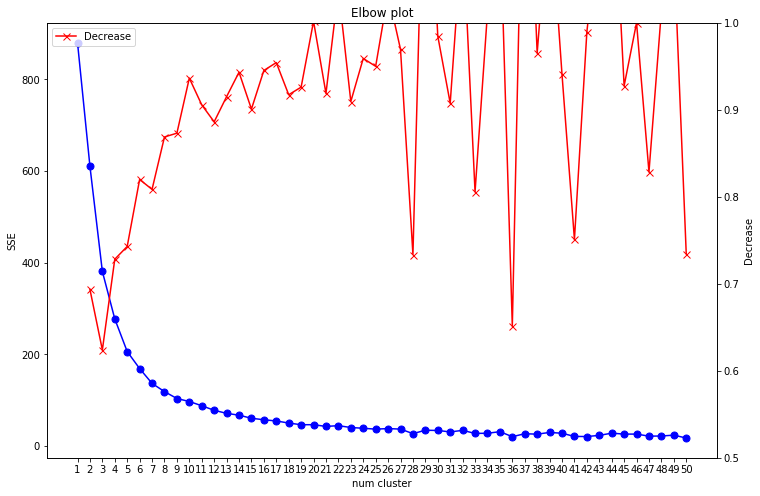

In [48]:
# エルボー図確認
plot_elbow_new(data_pca_std, 50, (12, 8))

クラスタ数k=15付近からSSEの減少率が約5%付近に収束していることが分かる。

実際に図にプロットしてみる。

In [49]:
def plot_cluster_new(X, model, figsize=(6, 4)):
    """
    与えられたデータから所属クラスタを予測してプロットする
    """
    _assigned_cluster = model.predict(X)
    _mu = model.mu

    %matplotlib inline
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_title('K-means clustering')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    for c in range(model.n_clusters):
        Xc = X[_assigned_cluster == c]
        ax.scatter(Xc[:, 0], Xc[:, 1], label=c)

    ax.scatter(_mu[:, 0], _mu[:, 1], color='black', marker='x', label="mu")
    plt.legend()
    plt.show()

Done! elapsed time: 1.17165s


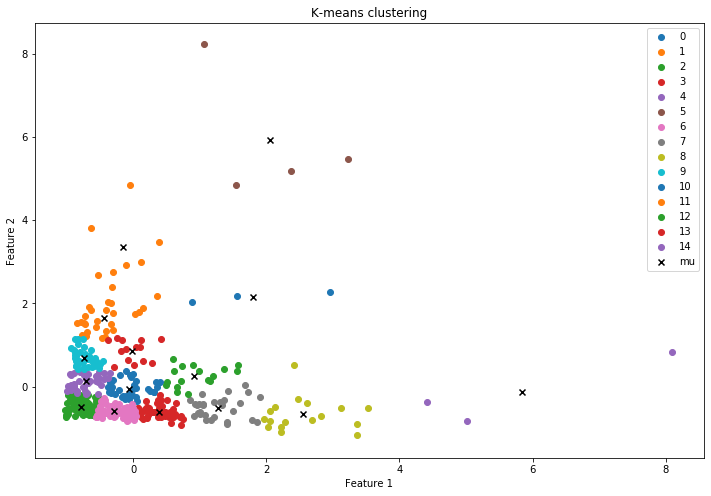

In [50]:
# n_clusters = 15
skm = ScratchKMeans(n_clusters=15, n_init=50, max_iter=50, tol=1.0e-6)
skm.fit(data_pca_std)
plot_cluster_new(data_pca_std, skm, (12, 8))

原点付近で過剰なクラスタリングが行われているように見えるのでクラスタ数を減らす。

Done! elapsed time: 0.87137s


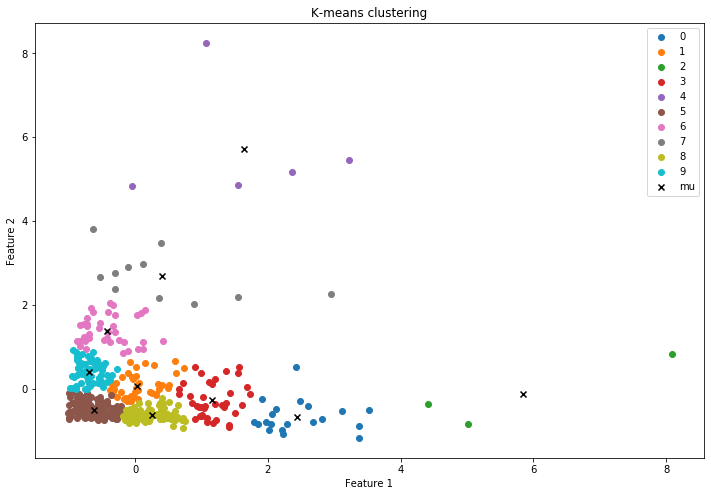

In [51]:
# n_clusters = 10
skm = ScratchKMeans(n_clusters=10, n_init=50, max_iter=50, tol=1.0e-6)
skm.fit(data_pca_std)
plot_cluster_new(data_pca_std, skm, (12, 8))

大きく外れている点群と小さく外れている点群をうまく分けられているように見えるため、k=10とする。

# 【問題11】
## 既知のグループとの比較
RegionとChannelはK-meansに使用しなかったが、これれらは既知のグループです。クラスタとこれら既知のグループがどう違うかを確認し、説明してください。まずはそれぞれを可視化してください。

In [52]:
data_new = pd.read_csv('Wholesale customers data.csv')
data_channel = data_new['Channel'].values
data_region = data_new['Region'].values
print(np.unique(data_channel))
print(np.unique(data_region))

[1 2]
[1 2 3]


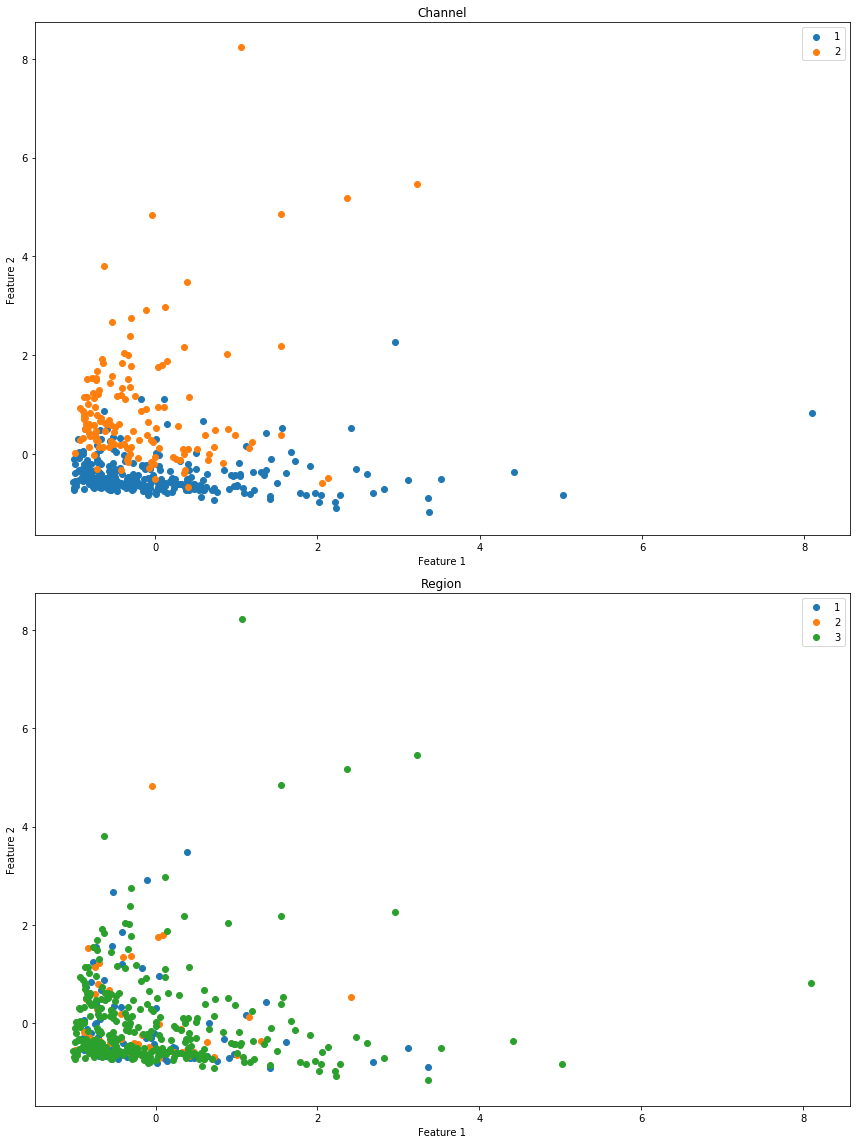

In [53]:
data_pca_channel = np.concatenate((data_channel.reshape(-1, 1), data_pca), axis=1)
data_pca_region = np.concatenate((data_region.reshape(-1, 1), data_pca), axis=1)

%matplotlib inline
fig = plt.figure(figsize=(12, 16))

ax1 = fig.add_subplot(211)
ax1.set_title('Channel')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
for i in np.unique(data_channel):
    data_tmp = data_pca_std[data_channel == i]
    ax1.scatter(data_tmp[:, 0], data_tmp[:, 1], label=i)
plt.legend()

ax2 = fig.add_subplot(212)
ax2.set_title('Region')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
for i in np.unique(data_region):
    data_tmp = data_pca_std[data_region == i]
    ax2.scatter(data_tmp[:, 0], data_tmp[:, 1], label=i)
plt.legend()

plt.tight_layout()
plt.show()

## Channel
k=10におけるクラスタリング結果との相関がみられる。

小売店/飲食施設の分類なので、購入の傾向は違いそう。
## Region
クラスタリングと比べて、あまり相関は見られなかった。

# 【問題12】
## 卸売業者にとって有益な情報
卸売業者にとって有益な情報を探し出し文章にまとめてください。


**《ヒント》**


前処理を行う前のデータを使い、各クラスタの要約統計量を見るなどしてみましょう。また、PCAで次元削減したデータに対してK-meansを使用しましたが、6個の特徴量をそのまま使ったり、一部の特徴量のみを使ったりということも試してみてください。既知のグループとの比較結果も参考にしてください。


条件ごとにデータを見る際にはPandasの`groupby`が便利です。


[pandas.DataFrame.groupby — pandas 0.23.4 documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html)

In [54]:
data_cluster = pd.read_csv('Wholesale customers data.csv')
data_cluster['Cluster'] = skm.predict(data_pca_std)
display(data_cluster)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Cluster
0,2,3,12669,9656,7561,214,2674,1338,1
1,2,3,7057,9810,9568,1762,3293,1776,9
2,2,3,6353,8808,7684,2405,3516,7844,9
3,1,3,13265,1196,4221,6404,507,1788,8
4,2,3,22615,5410,7198,3915,1777,5185,3
...,...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204,3
436,1,3,39228,1431,764,4510,93,2346,0
437,2,3,14531,15488,30243,437,14841,1867,7
438,1,3,10290,1981,2232,1038,168,2125,5


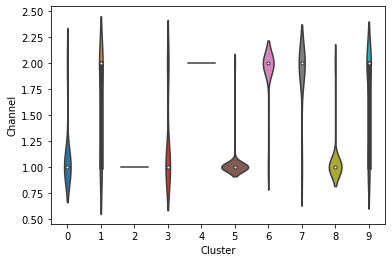

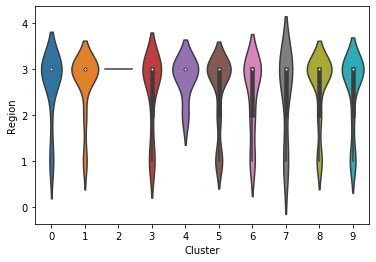

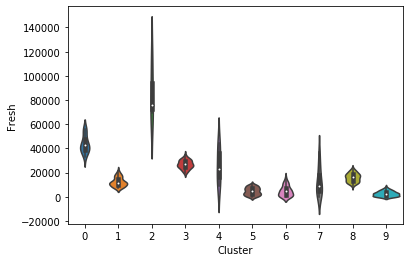

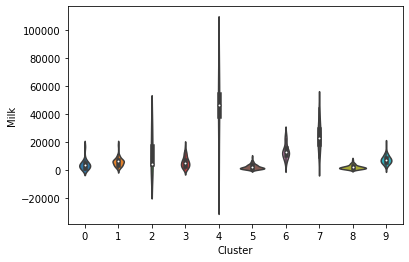

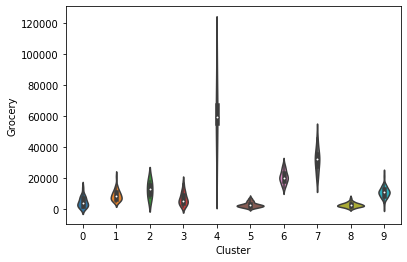

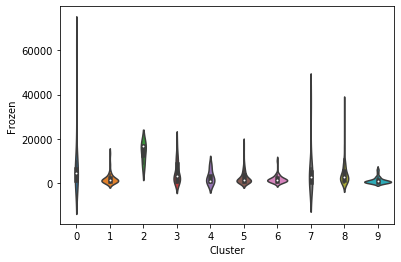

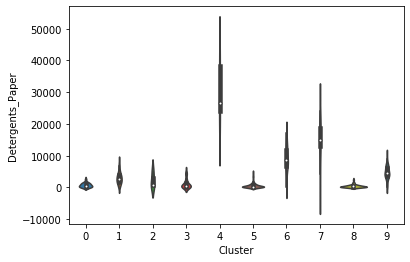

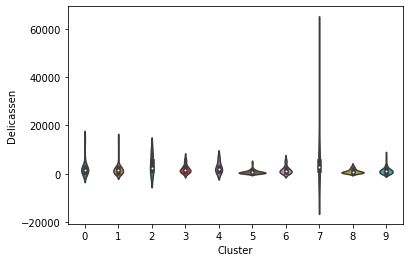

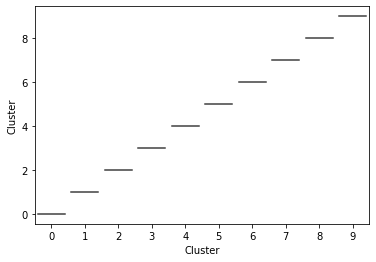

In [56]:
# クラスタごとに購入金額の分布を見る
import seaborn as sns
for f in data_cluster.columns:
    sns.violinplot(x='Cluster', y=f, data=data_cluster)
    plt.show()

- channel = 1 : cluster = 0, 2, 3, 5, 8
- channel = 2 : cluster = 1, 4, 6, 7, 9

という傾向がある。次にChannelごとのカラムの分布をもう少し見やすくしてみる。

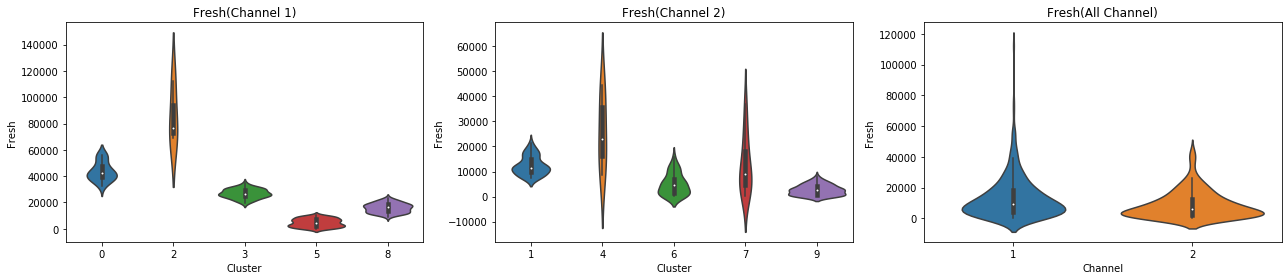

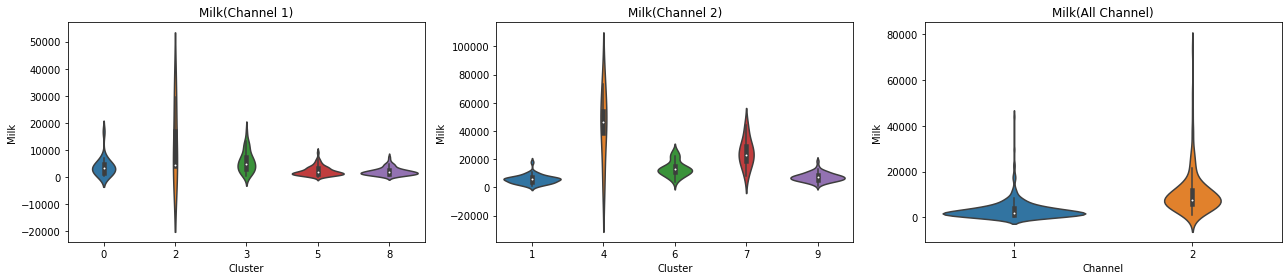

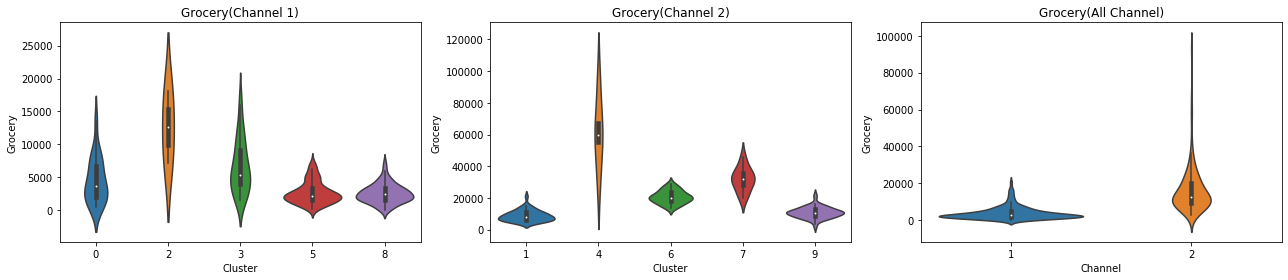

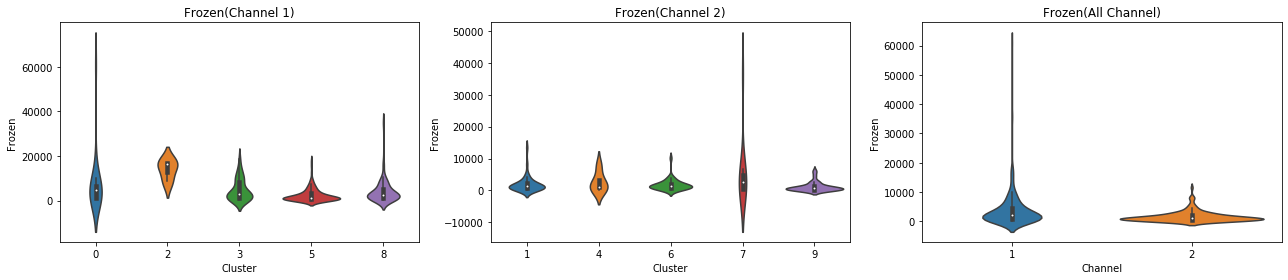

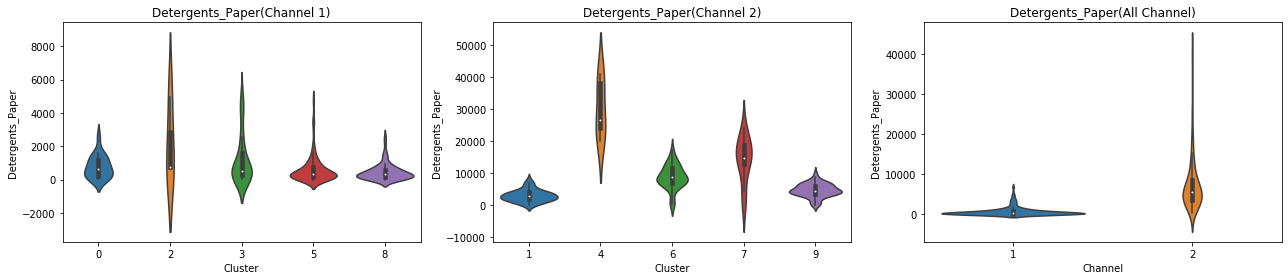

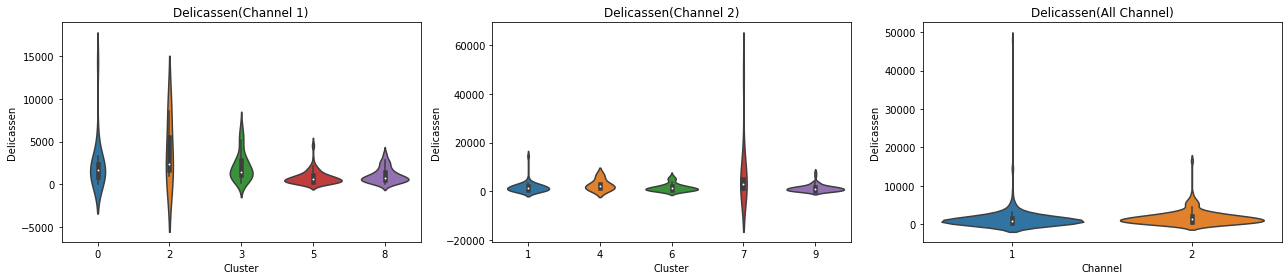

In [66]:
# Channelごとの購入金額の分布
data_channel_1 = data_cluster[
    (data_cluster['Cluster'] == 0)
    | (data_cluster['Cluster'] == 2)
    | (data_cluster['Cluster'] == 3)
    | (data_cluster['Cluster'] == 5)
    | (data_cluster['Cluster'] == 8)]

data_channel_2 = data_cluster[
    (data_cluster['Cluster'] == 1)
    | (data_cluster['Cluster'] == 4)
    | (data_cluster['Cluster'] == 6)
    | (data_cluster['Cluster'] == 7)
    | (data_cluster['Cluster'] == 9)]

for f in data.columns:
    fig = plt.figure(figsize=(18, 4))
    
    # channel1
    ax = fig.add_subplot(131)
    ax.set_title(f'{f}(Channel 1)')
    sns.violinplot(x='Cluster', y=f, data=data_channel_1)
    
    # channel_2
    ax = fig.add_subplot(132)
    ax.set_title(f'{f}(Channel 2)')
    sns.violinplot(x='Cluster', y=f, data=data_channel_2)
    
    # all channel
    ax = fig.add_subplot(133)
    ax.set_title(f'{f}(All Channel)')
    sns.violinplot(x='Channel', y=f, data=data_cluster)

    plt.tight_layout()
    plt.show()

In [71]:
print(data_cluster['Channel'].value_counts())

1    298
2    142
Name: Channel, dtype: int64


In [69]:
print(data_cluster['Channel'].value_counts())

1    298
2    142
Name: Channel, dtype: int64


全体的にchannel1に比べてchannel2のほうが購入価格が高くなっている。

Channel1=食品サービス業界、Channel2=小売店ということなので、小売店にやや営業のウェイトを置くのが良いのかもしれない。

そのChannel2について見てみると、Milk(牛乳)、Grocery(食品雑貨)、Detergents_Paper(衛生用品・紙類)の購入額が高いので、ここに分類される商品を中心に売るのがよい。

クラスタについては、2, 4, 7番クラスタに当たる顧客が全体的に購入額が高い傾向にあるので、それぞれのChannel内ではこのクラスタに分類される顧客へのサービスを充実させる必要がある。

これらのクラスタについては購入額が高額な顧客が一定数存在するため、リソースを割くことで全体の業績向上につながると考えられる。